In [ ]:
import requests
import pandas as pd
from PIL import Image
from io import BytesIO

In [ ]:
class YouTube_API():
    def __init__(self, video_category_Id=1, max_results=50) -> None:
        self.url = 'https://youtube.googleapis.com/youtube/v3/videos'
        self.part = 'snippet, statistics'
        self.chart = 'mostPopular'
        self.max_results = max_results
        self.video_category_Id = video_category_Id
        self.next_page_token = ''
        self.API_KEY = self.get_api_key()
        self.payload = {}
        self.request = None
        self.data_list = []
    
    # Retrieve api key from key.txt file.
    def get_api_key(self) -> str:
        with open('../api-key/key.txt', 'rt', encoding='utf-16') as f:
            key =  f.readline()
        f.close()
        return key
    
    # Set the URL-query parameter.
    def set_payload(self) -> None:
        # Set the next page token if it exists.
        try:
            self.next_page_token = self.request.json()['nextPageToken']
            self.payload['pageToken'] = self.next_page_token

        except: self.next_page_token = ''

        self.payload = {'part': self.part, 
                        'chart': self.chart, 
                        'maxResults': self.max_results, 
                        'videoCategoryId': self.video_category_Id,
                        'pageToken': self.next_page_token,
                        'key': self.API_KEY}

    # Send HTTP GET request with the provided URL and URL-qurry.
    def send_get_request(self) -> None:
        self.set_payload()
        self.request = requests.get(self.url, self.payload)
        
    # Retrive the total results number from response json.
    def set_total_results(self) -> None:
        self.total_results = self.request.json()['pageInfo']['totalResults']

    # Save extracted information in a data frame and return them.
    def get_data(self) -> object:
        print('Loading data...')
        self.send_get_request()
        self.set_total_results()
        retrived_pages = 0

        while self.total_results > 0 and self.request.status_code == 200:
            retrived_pages += 1
            self.set_data()
            self.total_results -= self.max_results
            self.send_get_request()

        print(f'Number of retrived pages: {retrived_pages}')    
        self.data = pd.concat(self.data_list)
        del self.data_list
        
        return self.data

    # Extract all nedded information from the response json of each page and save them in a dataframe.
    def set_data(self) -> None:
            data_json = self.request.json()
            items = data_json['items']
            snippets = [item['snippet'] for item in items]
            statistics = [item['statistics'] for item in items]
            published_at_list = [snip['publishedAt'] for snip in snippets]
            titles = [snip['title'] for snip in snippets]
            descriptions = [snip['description'] for snip in snippets]
            thumbnail_urls = [snip['thumbnails']['high']['url'] for snip in snippets]
            view_counts = [stat['viewCount'] for stat in statistics]

            like_counts = []
            for stat in statistics:
                try: like_counts.append(stat['likeCount'])
                except : like_counts.append(None)
            
            comment_counts = []
            for stat in statistics:
                try: comment_counts.append(stat['commentCount'])
                except :comment_counts.append(None)

            self.data_list.append(pd.DataFrame({'title': titles, 
                                'description': descriptions,
                                'view_count': view_counts,
                                'like_count': like_counts,
                                'comment_count': comment_counts,
                                'published_at': published_at_list,
                                'thumbnail_url': thumbnail_urls}))

    # Display a video detailed information besed on a given index.
    def display_video_details(self, index:int) -> object:
        try:
            print(self.data.iloc[index, :])
            req = requests.get(self.data.thumbnail_url.values[index])
            return Image.open(BytesIO(req.content))
        except:
            print('Entry could not be found!')
    
    # Display a video thumbnail image based on a given index.
    def display_video_thumbnail(self, index:int) -> object:
        try:
            request = requests.get(self.data.thumbnail_url.values[index])
            return Image.open(BytesIO(request.content))
        except:
            print('Image could not be found!')

In [24]:
api = YouTube_API(video_category_Id=24)

In [26]:
df = api.get_data()
df.sample(5)

Loading data...
Number of retrived pages: 4


,title,description,view_count,like_count,comment_count,published_at,thumbnail_url
29,JOJO & The Bonnet Brothers SEASON FINALE 🫣,"🚨NEW VIDEOS every TUESDAY, THURSDAY and SUNDAY...",482265,8251,433,2022-07-29T01:26:12Z,https://i.ytimg.com/vi/gz-Ki47A4Is/hqdefault.jpg
7,Can Benny The Bull Cure Deanobballin?! 😳,Is Benny The Bull My Cure?! Full Video Is Live...,879853,78061,674,2022-07-29T19:35:59Z,https://i.ytimg.com/vi/nI1AlleEkdc/hqdefault.jpg
47,At Least He Got Into Heaven😂😂,,2839720,276535,1865,2022-07-27T00:49:07Z,https://i.ytimg.com/vi/6jIRWx0N9lU/hqdefault.jpg
23,BLONDE | Official Trailer | Netflix,Discover a life both known and unknown in this...,6182092,191698,8180,2022-07-28T13:00:03Z,https://i.ytimg.com/vi/aIsFywuZPoQ/hqdefault.jpg
0,We Spent a Day with @AnthonyPadilla | Trash Ta...,📦Go to https://partner.bokksu.com/trashtaste a...,772586,41849,1908,2022-07-29T20:00:11Z,https://i.ytimg.com/vi/I6EKOnqlN48/hqdefault.jpg


In [27]:
df.shape

(200, 7)

In [28]:
df.duplicated().sum()

0

title                  Jason Todd replaces Batman after his death
description                                                      
view_count                                                2508745
like_count                                                 280995
comment_count                                                1598
published_at                                 2022-07-22T15:30:23Z
thumbnail_url    https://i.ytimg.com/vi/uvYNyxVavRM/hqdefault.jpg
Name: 20, dtype: object


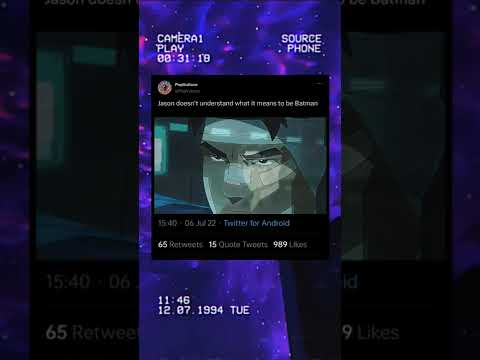

In [29]:
api.display_video_details(120)

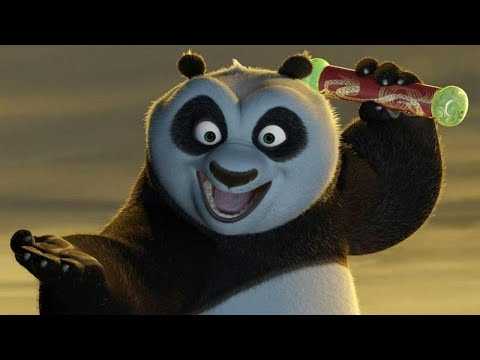

In [31]:
api.display_video_thumbnail(192)

In [25]:
# Print YouTube vido categories and their ids.
categories = '2 - Autos & Vehicles,  1 - Film & Animation, 10 - Music, 15 - Pets & Animals, 17 - Sports, 18 - Short Movies, 19 - Travel & Events, 20 - Gaming, 21 - Videoblogging, 22 - People & Blogs, 23 - Comedy, 24 - Entertainment, 25 - News & Politics, 26 - Howto & Style, 27 - Education, 28 - Science & Technology, 29 - Nonprofits & Activism, 30 - Movies, 31 - Anime/Animation, 32 - Action/Adventure, 33 - Classics, 34 - Comedy, 35 - Documentary, 36 - Drama, 37 - Family, 38 - Foreign, 39 - Horror, 40 - Sci-Fi/Fantasy, 41 - Thriller, 42 - Shorts, 43 - Shows, 44 - Trailers'
categories = categories.split(', ')
modified_cats = []

for cat in categories:
    new_cat = cat.split(' - ')
    new_cat = {'id': int(new_cat[0]), 'category': new_cat[1]}
    modified_cats.append(new_cat)
    
modified_cats.sort(key=lambda x: x['id'])

for item in modified_cats:
    print(f'ID: {item["id"]}  ({item["category"]})')

ID: 1  (Film & Animation)
ID: 2  (Autos & Vehicles)
ID: 10  (Music)
ID: 15  (Pets & Animals)
ID: 17  (Sports)
ID: 18  (Short Movies)
ID: 19  (Travel & Events)
ID: 20  (Gaming)
ID: 21  (Videoblogging)
ID: 22  (People & Blogs)
ID: 23  (Comedy)
ID: 24  (Entertainment)
ID: 25  (News & Politics)
ID: 26  (Howto & Style)
ID: 27  (Education)
ID: 28  (Science & Technology)
ID: 29  (Nonprofits & Activism)
ID: 30  (Movies)
ID: 31  (Anime/Animation)
ID: 32  (Action/Adventure)
ID: 33  (Classics)
ID: 34  (Comedy)
ID: 35  (Documentary)
ID: 36  (Drama)
ID: 37  (Family)
ID: 38  (Foreign)
ID: 39  (Horror)
ID: 40  (Sci-Fi/Fantasy)
ID: 41  (Thriller)
ID: 42  (Shorts)
ID: 43  (Shows)
ID: 44  (Trailers)
